# Setting GPU Memory

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8024)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

# Importing Libraries

In [128]:
import pandas as pd
import numpy as np

import os
import sys
from glob import glob

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Preparation

In [129]:
# Paths for data.
Ravdess = "/home/lab10/data/RAVDESS/"
Crema = "/home/lab10/data/CREMA-D/AudioWAV/"
Tess = "/home/lab10/data/TESS/"
Savee = "/home/lab10/data/SAVEE/AudioData/"
Iemocap = '/home/lab10/data/IEMOCAP/'

##  1. Ravdess Dataframe

In [138]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# check number of files
print("Number of filr_emotion : %d" % len(file_emotion))
print("Number of file_path : %d" % len(file_path))

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Number of filr_emotion : 1440
Number of file_path : 1440


Emotions                                               Path
0   disgust  /home/lab10/data/RAVDESS/Actor_12/03-01-07-02-...
1  surprise  /home/lab10/data/RAVDESS/Actor_12/03-01-08-01-...
2      calm  /home/lab10/data/RAVDESS/Actor_12/03-01-02-01-...
3      calm  /home/lab10/data/RAVDESS/Actor_12/03-01-02-01-...
4  surprise  /home/lab10/data/RAVDESS/Actor_12/03-01-08-02-...

## 2. Crema DataFrame

In [139]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# check number of files
print("Number of filr_emotion : %d" % len(file_emotion))
print("Number of file_path : %d" % len(file_path))

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Number of filr_emotion : 7442
Number of file_path : 7442


Emotions                                               Path
0      sad  /home/lab10/data/CREMA-D/AudioWAV/1033_TIE_SAD...
1      sad  /home/lab10/data/CREMA-D/AudioWAV/1057_MTI_SAD...
2     fear  /home/lab10/data/CREMA-D/AudioWAV/1040_IWW_FEA...
3    happy  /home/lab10/data/CREMA-D/AudioWAV/1005_ITS_HAP...
4      sad  /home/lab10/data/CREMA-D/AudioWAV/1018_MTI_SAD...

##  3. TESS dataset

In [140]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for file in tess_directory_list:
    # storing file paths
    part = file.split('.')[0]
    part = part.split('_')[2]
    if part=='ps':
        file_emotion.append('surprise')
    else:
        file_emotion.append(part)
    file_path.append(Tess + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# check number of files
print("Number of filr_emotion : %d" % len(file_emotion))
print("Number of file_path : %d" % len(file_path))

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Number of filr_emotion : 2800
Number of file_path : 2800


Emotions                                      Path
0  surprise    /home/lab10/data/TESS/YAF_cause_ps.wav
1  surprise      /home/lab10/data/TESS/OAF_gun_ps.wav
2     happy  /home/lab10/data/TESS/YAF_soap_happy.wav
3  surprise    /home/lab10/data/TESS/YAF_goose_ps.wav
4       sad    /home/lab10/data/TESS/OAF_mood_sad.wav

##  5. SAVEE dataset

In [142]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for dir in savee_directory_list:
    actor = os.listdir(Savee + dir)
    for file in actor:      
        ele = file[0]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif file[0:2]=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
        file_path.append(Savee + dir + '/' + file)     
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# check number of files
print("Number of filr_emotion : %d" % len(file_emotion))
print("Number of file_path : %d" % len(file_path))

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Number of filr_emotion : 480
Number of file_path : 480


Emotions                                          Path
0   disgust   /home/lab10/data/SAVEE/AudioData/JK/d09.wav
1       sad  /home/lab10/data/SAVEE/AudioData/JK/sa04.wav
2  surprise  /home/lab10/data/SAVEE/AudioData/JK/su11.wav
3  surprise  /home/lab10/data/SAVEE/AudioData/JK/su04.wav
4     happy   /home/lab10/data/SAVEE/AudioData/JK/h08.wav

##  5. IEMOCAP dataset 


In [143]:
iemocap_directory_list = sorted(os.listdir(Iemocap))

file_emotion = []
file_path = []

for speaker in iemocap_directory_list:
    sub_dir = os.path.join(Iemocap, speaker,'sentences/wav')
    emoevl = os.path.join(Iemocap, speaker,'dialog/EmoEvaluation')
    for sess in os.listdir(sub_dir):   # sess: 최하위 dir
        emotdir = emoevl+'/'+sess+'.txt'
        emot_map = {}
        with open(emotdir,'r') as emot_to_read:
            while True:
                line = emot_to_read.readline()
                if not line:
                    break
                if(line[0] == '['):
                    t = line.split()
                    emot_map[t[3]] = t[4]
        files = glob((os.path.join(sub_dir, sess, '*.wav')))        
        for file_dir in files:
            wavname = file_dir.split("/")[-1][:-4]
            emotion = emot_map[wavname]
            if emotion=='neu':
                file_emotion.append('neutral')
            elif emotion=='hap':
                file_emotion.append('happy')
            elif emotion=='sad':
                file_emotion.append('sad')                
            elif emotion=='ang':
                file_emotion.append('angry')
            elif emotion=='sur':
                file_emotion.append('surprise')
            elif emotion=='fea':
                file_emotion.append('fear')
            elif emotion=='dis':
                file_emotion.append('disgust')
            else:
                continue

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# check number of files
print("Number of filr_emotion : %d" % len(file_emotion))
print("Number of file_path : %d" % len(file_path))

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Iemocap_df = pd.concat([emotion_df, path_df], axis=1)
Iemocap_df.head()

Number of filr_emotion : 4639
Number of file_path : 4639


Emotions                                               Path
0    angry  /home/lab10/data/IEMOCAP/Session1/sentences/wa...
1    angry  /home/lab10/data/IEMOCAP/Session1/sentences/wa...
2    angry  /home/lab10/data/IEMOCAP/Session1/sentences/wa...
3    angry  /home/lab10/data/IEMOCAP/Session1/sentences/wa...
4  neutral  /home/lab10/data/IEMOCAP/Session1/sentences/wa...

In [144]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df, Iemocap_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0   disgust  /home/lab10/data/RAVDESS/Actor_12/03-01-07-02-...
1  surprise  /home/lab10/data/RAVDESS/Actor_12/03-01-08-01-...
2      calm  /home/lab10/data/RAVDESS/Actor_12/03-01-02-01-...
3      calm  /home/lab10/data/RAVDESS/Actor_12/03-01-02-01-...
4  surprise  /home/lab10/data/RAVDESS/Actor_12/03-01-08-02-...

# Data Visualisation and Exploration

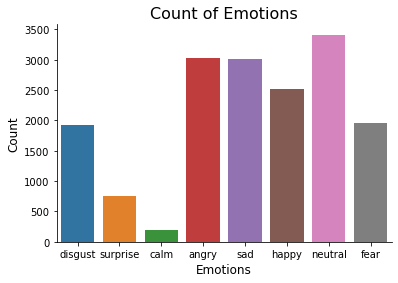

In [145]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [146]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

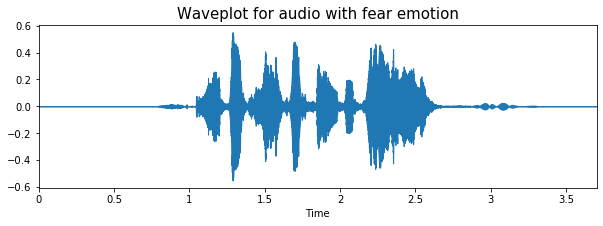

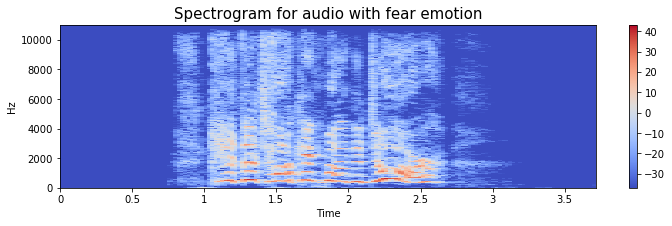

In [147]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

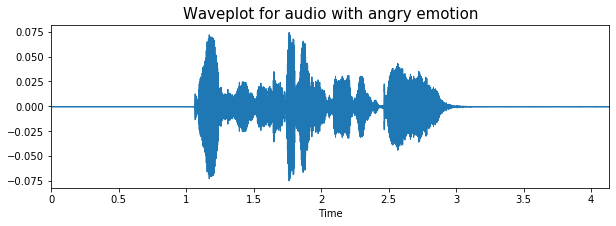

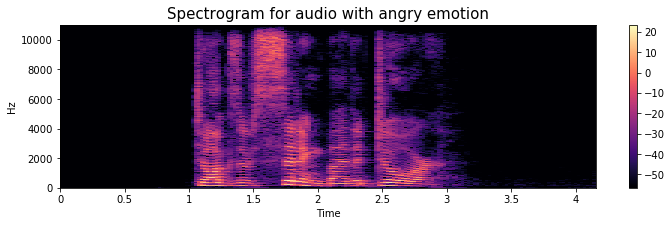

In [18]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

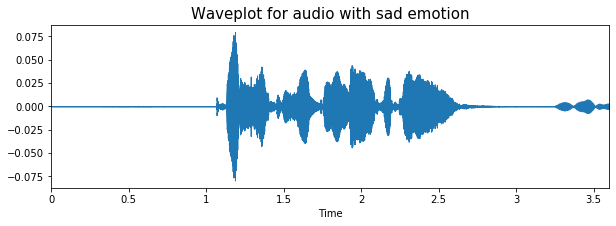

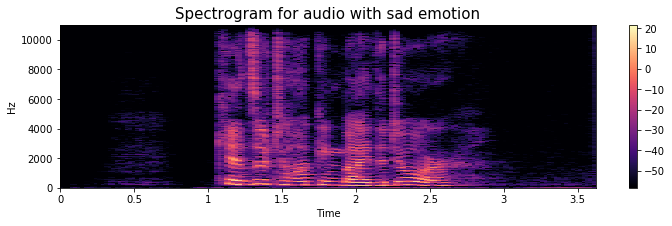

In [148]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

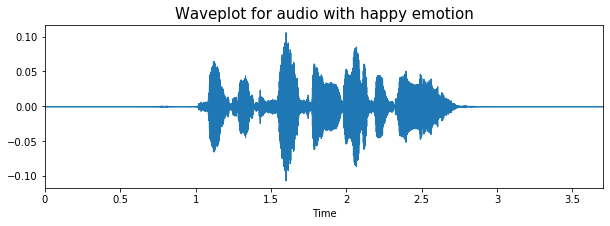

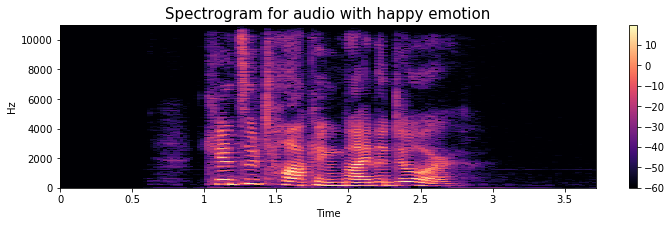

In [20]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

- Noise Injection
- Stretching
- Shifting
- Pitch

In [149]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

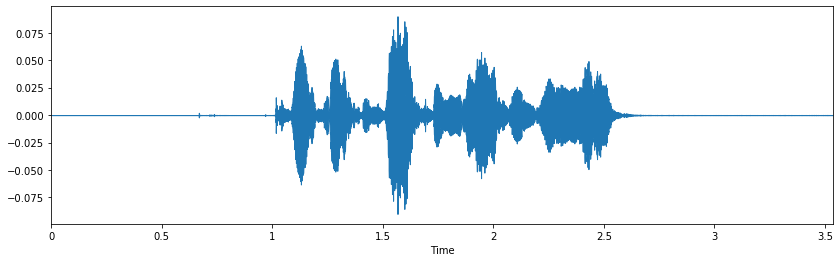

In [150]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

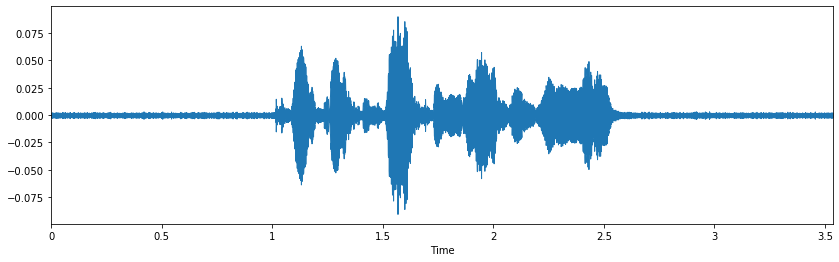

In [151]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

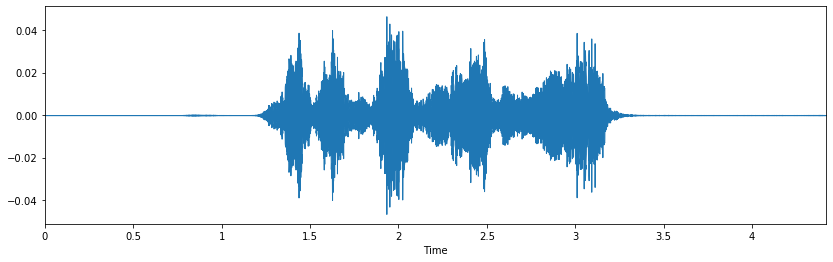

In [24]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

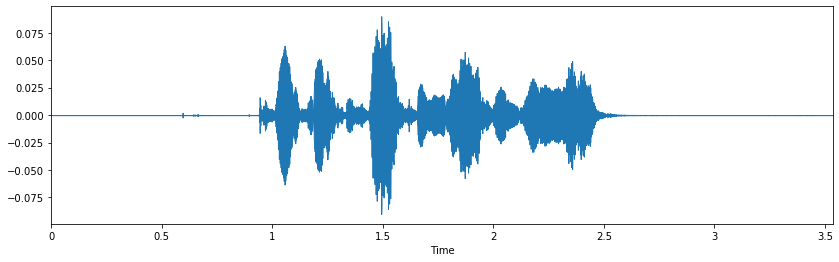

In [25]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

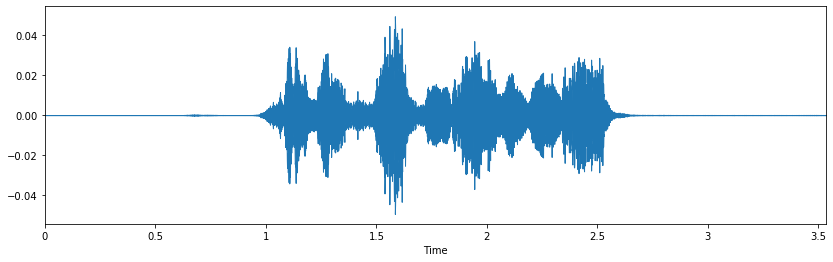

In [26]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [185]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3.0, offset=0.2)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [225]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [315]:
len(X), len(Y), data_path.Path.shape

(50403, 50403, (16801,))

In [316]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.163601  0.574728  0.558548  0.543955  0.557603  0.568562  0.586432   
1  0.291004  0.673848  0.681632  0.678166  0.713616  0.728159  0.686196   
2  0.204288  0.624293  0.560268  0.533763  0.526394  0.529422  0.537765   
3  0.259649  0.696375  0.671913  0.653080  0.681897  0.704579  0.685878   
4  0.287534  0.733479  0.729448  0.711113  0.732546  0.776583  0.756437   

          7         8         9  ...       153       154       155       156  \
0  0.589669  0.572303  0.550951  ...  0.000337  0.000375  0.000410  0.000381   
1  0.654116  0.627609  0.624314  ...  0.000646  0.000686  0.000744  0.000703   
2  0.577781  0.590521  0.582999  ...  0.000143  0.000077  0.000088  0.000087   
3  0.624828  0.625134  0.626294  ...  0.000066  0.000056  0.000041  0.000122   
4  0.650210  0.667155  0.657647  ...  0.000074  0.000067  0.000051  0.000130   

        157       158       159       160           161    labels  
0  0.000398  0.000305  0.000232  0.000079  7.389657e-06   disgust  
1  0.000716  0.000600  0.000537  0.000380  3.163040e-04   disgust  
2  0.000088  0.000075  0.000065  0.000018  9.392133e-07   disgust  
3  0.000202  0.000074  0.000065  0.000020  9.774590e-07  surprise  
4  0.000211  0.000083  0.000074  0.000029  1.056514e-05  surprise  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation for Training and Testing

In [317]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [318]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [319]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37802, 162), (37802, 8), (12601, 162), (12601, 8))

In [320]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37802, 162), (37802, 8), (12601, 162), (12601, 8))

In [321]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37802, 162, 1), (37802, 8), (12601, 162, 1), (12601, 8))

## Modelling

In [325]:
version = '003'

In [336]:
# revised model
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 41, 256)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 21, 128)           0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 21, 128)         

In [337]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_{}.h5'.format(version),
                                             monitor='val_loss',
                                             save_best_only=True,),
            keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
            keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, min_lr=0.0000001),
            ]

history=model.fit(x_train, y_train, batch_size=64, epochs=300, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/300
589/591 [============================>.] - ETA: 0s - loss: 1.6499 - accuracy: 0.3562 - precision: 0.6389 - recall: 0.1015 - auc: 0.7845

ValueError: in user code:

    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


# Predicting on Test Data

In [330]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [331]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad       neutral
1          neutral       neutral
2          neutral           sad
3            angry         angry
4          neutral       neutral
5          disgust         happy
6          neutral       neutral
7          neutral       neutral
8            angry         angry
9            angry         angry

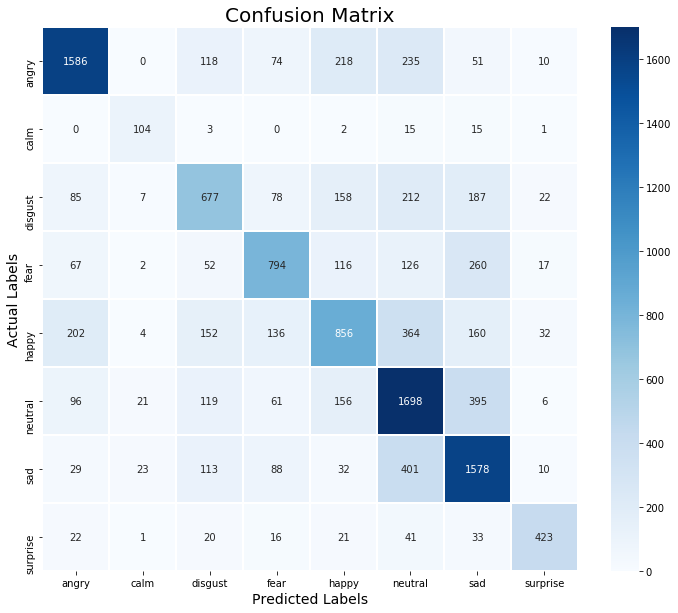

In [332]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [333]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.69      0.72      2292
        calm       0.64      0.74      0.69       140
     disgust       0.54      0.47      0.51      1426
        fear       0.64      0.55      0.59      1434
       happy       0.55      0.45      0.49      1906
     neutral       0.55      0.67      0.60      2552
         sad       0.59      0.69      0.64      2274
    surprise       0.81      0.73      0.77       577

    accuracy                           0.61     12601
   macro avg       0.63      0.63      0.63     12601
weighted avg       0.62      0.61      0.61     12601



# Data Preparation for Distribution

In [ ]:
"""
[최종 배포용 모델링]

train set과 test set 구분 없이 모든 dataset을 투입하여 모델링

최종 배포 모델 완성

"""

# Loading The Model

# Modeling for Distribution

In [ ]:
# revised model
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_{}.h5'.format(version),
                                             monitor='val_loss',
                                             save_best_only=True,),
            keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
            keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, min_lr=0.0000001),
            ]

history=model.fit(x_train, y_train, batch_size=64, epochs=300, validation_data=(x_test, y_test), callbacks=callbacks)

# Saving The Model

In [313]:
# 'angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'
encoder.categories_

[array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
        'surprise'], dtype=object)]

In [212]:
import json
from joblib import dump

# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models_{}'.format(version))
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_name = 'model_hdf5_{}.h5'.format(version)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_json_name = "model_{}.json".format(version)
model_json_path = os.path.join(save_dir, model_json_name)
model_json = model.to_json()
with open(model_json_path, "w") as json_file:
    json_file.write(model_json)    

model_scaler_name = 'scaler_{}.save'.format(version)
model_json_path = os.path.join(save_dir, model_scaler_name)
dump(scaler, model_json_path)

Saved trained model at /home/lab10/Speech-Emotion-Analyzer/saved_models_002/model_hdf5_002.h5 


['/home/lab10/Speech-Emotion-Analyzer/saved_models_002/scaler_002.save']